# Laboratorio 10 - Data Science
## Proyecto de Consultoría: Regresión Lineal con Python y Spark

- Nelson García Bravatti
- Christian Echeverría


In [2]:
!pip -q install pyspark

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Lab DF — Cruceros").getOrCreate()
print("Spark version:", spark.version)

Spark version: 3.5.1


In [8]:
file_path = '/content/barcos_crucero.csv'
df = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .csv(file_path)
)

# Ver las primeras filas del dataframe
df.show(5)

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
only showing top 5 rows



In [10]:
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [12]:
from pyspark.sql import functions as F, types as T

#Seleccionar columnas numéricas para describir
numeric_types = (T.DoubleType, T.IntegerType, T.LongType, T.FloatType, T.ShortType, T.DecimalType)
num_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, numeric_types)]

#Validar que existan columnas numéricas
if not num_cols:
    raise ValueError("No se detectaron columnas numéricas para describir. Revisa el esquema/lectura del CSV.")

#Descriptivos básicos
desc_basic = df.select(num_cols).describe()
desc_basic.show(truncate=False)

+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Age               |Tonnage           |passengers       |length           |cabins            |passenger_density|crew             |
+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|count  |158               |158               |158              |158              |158               |158              |158              |
|mean   |15.689873417721518|71.28467088607599 |18.45740506329114|8.130632911392404|8.830000000000005 |39.90094936708861|7.794177215189873|
|stddev |7.615691058751413 |37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615|8.63921711391542 |3.503486564627034|
|min    |4                 |2.329             |0.66             |2.79             |0.33              |17.7             |0.59             |
|max    |48                

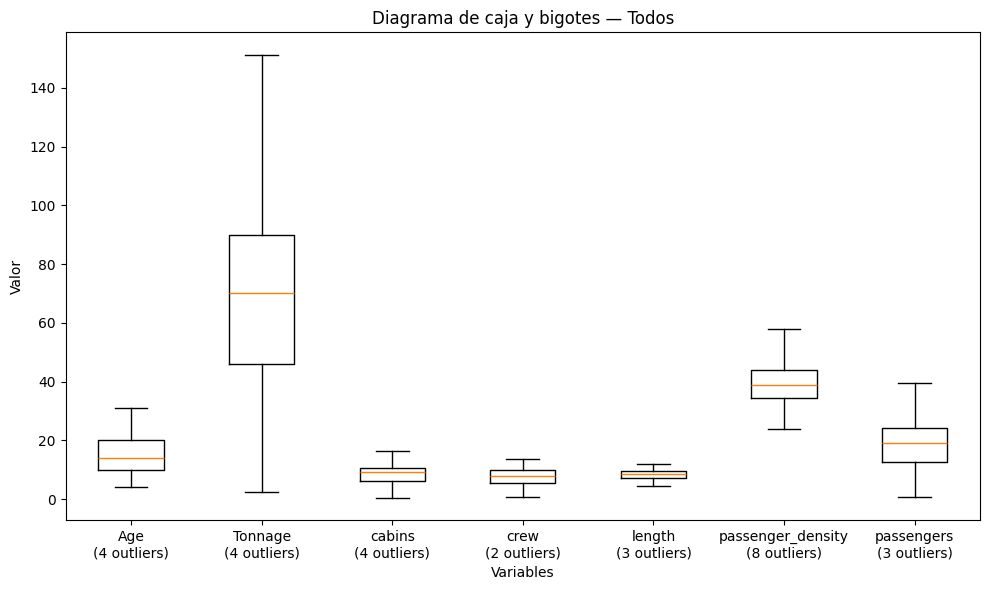

In [16]:
import matplotlib.pyplot as plt

def numeric_cols(sdf, include_decimal=True):
    numeric_types = {
        T.ByteType, T.ShortType, T.IntegerType, T.LongType,
        T.FloatType, T.DoubleType
    }
    if include_decimal:
        numeric_types.add(T.DecimalType)
    cols = []
    for f in sdf.schema.fields:
        if type(f.dataType) in numeric_types:
            cols.append(f.name)
    return cols

def boxplot_stats_spark(
    sdf,
    cols=None,
    by=None,
    whisker_coeff=1.5,
    approx_rel_err=0.01,
    max_groups=12
):
    # Detectar columnas numéricas si no se especifican
    if cols is None:
        numeric_types = {
            T.ByteType, T.ShortType, T.IntegerType, T.LongType,
            T.FloatType, T.DoubleType, T.DecimalType
        }
        cols = [f.name for f in sdf.schema.fields if type(f.dataType) in numeric_types]
    if not cols:
        raise ValueError("No se encontraron columnas numéricas en el DataFrame.")

    # Categorías (si aplica)
    groups = [None]
    if by:
        groups = [r[0] for r in (
            sdf.groupBy(by).count().orderBy(F.desc("count")).limit(max_groups).select(by).collect()
        )]

    results = {}
    prob = F.array(F.lit(0.25), F.lit(0.5), F.lit(0.75))
    acc = int(1/approx_rel_err)

    for g in groups:
        sdf_g = sdf if g is None else sdf.filter(F.col(by) == F.lit(g))
        group_key = "Todos" if g is None else f"{by}={g}"
        results[group_key] = {}

        for c in cols:
            # Filtra nulos/NaN antes de cualquier agregación
            flt = sdf_g.where(F.col(c).isNotNull() & ~F.isnan(F.col(c)))

            # Si no hay filas válidas, continuar
            if flt.limit(1).count() == 0:
                continue

            # Cuantiles
            q_row = flt.select(F.percentile_approx(F.col(c), prob, acc).alias("q")).collect()
            q1, med, q3 = q_row[0]["q"]
            if q1 is None or med is None or q3 is None:
                continue

            iqr = q3 - q1
            lower_bound = q1 - whisker_coeff * iqr
            upper_bound = q3 + whisker_coeff * iqr

            # Bigotes dentro de límites
            whis = (flt.select(
                F.min(F.when(F.col(c) >= lower_bound, F.col(c))).alias("whislo"),
                F.max(F.when(F.col(c) <= upper_bound, F.col(c))).alias("whishi")
            ).collect()[0])

            whislo = whis["whislo"]
            whishi = whis["whishi"]

            # Fallback si todo quedó fuera
            if whislo is None or whishi is None:
                mm = flt.select(F.min(c).alias("minv"), F.max(c).alias("maxv")).collect()[0]
                whislo = mm["minv"]
                whishi = mm["maxv"]

            # Conteo de outliers
            outliers_count = flt.filter((F.col(c) < lower_bound) | (F.col(c) > upper_bound)).count()

            results[group_key][c] = {
                "label": c,
                "med": float(med),
                "q1": float(q1),
                "q3": float(q3),
                "whislo": float(whislo) if whislo is not None else float(q1),
                "whishi": float(whishi) if whishi is not None else float(q3),
                "fliers": [],
                "outliers_count": int(outliers_count),
            }
    return results

def plot_boxplots_from_stats(stats_dict, figsize=(10,6)):
    """
    stats_dict es el resultado de boxplot_stats_spark.
    Si tiene múltiples grupos, se crea una figura por grupo.
    """
    for group_key, per_col in stats_dict.items():
        if not per_col:
            continue
        fig = plt.figure(figsize=figsize)
        ax = plt.gca()

        ordered = sorted(per_col.values(), key=lambda d: d["label"])
        # Matplotlib bxp espera dicts con med, q1, q3, whislo, whishi, fliers
        ax.bxp(ordered, showfliers=True)
        ax.set_title(f"Diagrama de caja y bigotes — {group_key}")
        ax.set_ylabel("Valor")
        ax.set_xlabel("Variables")

        xticks = ax.get_xticklabels()
        for i, lbl in enumerate(xticks):
            var = ordered[i]["label"]
            oc = per_col[var]["outliers_count"]
            lbl.set_text(f"{var}\n({oc} outliers)")
        ax.set_xticklabels(xticks, rotation=0)
        plt.tight_layout()
        plt.show()

# Boxplots de todas las columnas numéricas:
stats = boxplot_stats_spark(df)
plot_boxplots_from_stats(stats)

